In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
models_5d_path = os.path.join(cwd, '..', 'models_5d_gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [4]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           xtry_langevin_sampling_plot_2d,
                           epoch_visualization)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          xtry_langevin_sampling,
                          gan_energy,
                          Gaussian_mixture,
                          IndependentNormal,
                          DotDict)
from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)
from metrics import Evolution, plot_chain_metrics

from sklearn import mixture

In [5]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [6]:
n_dim = 2
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = Gaussian_mixture(target_args).log_prob


n_dim = 2
loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [9]:
n_steps = 50
grad_step = 1e-3
eps_scale = 1e-2
n = 5000
batch_size = 5000

In [60]:
X_gen, _ = langevin_sampling(true_target, proposal, n_steps, grad_step, eps_scale, n, batch_size)

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


In [161]:
@torch.no_grad()
def get_pis_estimate(X_gen, target_log_prob, n_pts=4000, sample_method='grid', density_method='gmm'):
    target_pdf = lambda x: target_log_prob(torch.FloatTensor(x)).exp().detach().cpu().numpy()

    if density_method == 'kde':
        G_ker = gaussian_kde(X_gen.detach().cpu().numpy().reshape(2, -1))
        pi_g_f = lambda x: G_ker.pdf(x.reshape(2, -1))

    elif density_method == 'gmm':
        gm_g = mixture.GaussianMixture(n_components=25)
        gm_g.fit(X_gen.detach())
        pi_g_f = lambda x: np.exp(gm_g.score_samples(x))
    optD = lambda x: target_pdf(x) / (target_pdf(x) + pi_g_f(x) + 1e-8)

    if sample_method == 'grid':
        n_pts = int(n_pts**.5)
        X = np.mgrid[-3:3:4./n_pts, -3:3:4./n_pts].reshape(2, -1).T
    elif sample_method == 'mc':
        pass
        #X = 4*torch.rand(n_pts, 2) - 2.

    pi_d = target_pdf(X) #gm.pdf(X)
    pi_g = pi_g_f(X)

    opt_ds = optD(X)
    opt_ds[pi_d < 1e-9] = 0.

    return pi_d, pi_g, opt_ds, X


class Evolution(object):
    def __init__(self, target_sample, **kwargs):#locs, sigma, target_log_prob, target_sample, sigma=0.05, scaler=None):
        self.locs = kwargs.get('locs', None)
        self.sigma = kwargs.get('sigma', None)
        self.target_log_prob = kwargs.get('target_log_prob', None)
        self.target_sample = target_sample
        self.scaler = kwargs.get('scaler', None)

        self.mode_std = []
        self.high_quality_rate = []
        self.jsd = []
        self.emd = []

        self.kl_pis = []
        self.js_pis = []
        self.l2_div = []

    @staticmethod
    def make_assignment(X_gen, locs, sigma=0.05):
        n_modes, x_dim = locs.shape
        dists = torch.norm((X_gen[:, None, :] - locs[None, :, :]), p=2, dim=-1)
        assignment = dists < 4 * sigma
        return assignment

    @staticmethod
    def compute_mode_std(X_gen, assignment):
        """
        X_gen(torch.FloatTensor) - (n_pts, x_dim)
        
        """
        x_dim = X_gen.shape[-1]
        n_modes = assignment.shape[1]
        std = 0
        for mode_id in range(n_modes):
            xs = X_gen[assignment[:, mode_id]]
            if xs.shape[0] > 1:
                std_ = (1 / (2**(x_dim - 1) * (xs.shape[0] - 1)) * ((xs - xs.mean(0))**2).sum())**.5
                std += std_
        std /= n_modes
        return std

    @staticmethod
    def compute_high_quality_rate(assignment):
        high_quality_rate = assignment.max(1)[0].sum() / float(assignment.shape[0])
        return high_quality_rate

    @staticmethod
    def compute_jsd(assignment):
        n_modes = assignment.shape[1]
        assign_ = torch.cat([assignment, torch.zeros(assignment.shape[0]).unsqueeze(1)], -1)
        assign_[:, -1][assignment.sum(1) == 0] = 1
        sample_dist = assign_.sum(dim=0) / float(assign_.shape[0])
        sample_dist /= sample_dist.sum()
        uniform_dist = torch.FloatTensor([1. / n_modes for _ in range(n_modes)] + [0]).to(assignment.device)
        M = .5 * (uniform_dist + sample_dist)
        JSD = .5 * (sample_dist * torch.log((sample_dist + 1e-7) / M)) + .5 * (uniform_dist * torch.log((uniform_dist + 1e-7) / M))

        JSD[sample_dist == 0.] = 0.
        JSD[uniform_dist == 0.] = 0.
        JSD = JSD.sum()

        return JSD

    @staticmethod
    def compute_emd(target_sample, gen_sample):
        gen_sample = gen_sample[np.random.choice(np.arange(gen_sample.shape[0]), target_sample.shape[0])]
        M = np.linalg.norm(target_sample[None, :, :] - gen_sample[:, None, :], axis=-1, ord=2)**2
        emd = np.sum(ot.emd([], [], M) * M)

        return emd

    def invoke(self, X_gen, D=None, compute_discrim_div=False):
        if self.locs is not None and self.sigma is not None:
            assignment = Evolution.make_assignment(X_gen, self.locs, self.sigma)
            mode_std = Evolution.compute_mode_std(X_gen, assignment)
            self.mode_std.append(mode_std.item())
            h_q_r = Evolution.compute_high_quality_rate(assignment)
            self.high_quality_rate.append(h_q_r.item())
            jsd = Evolution.compute_jsd(assignment)
            self.jsd.append(jsd.item())

        emd = self.compute_emd(self.target_sample, X_gen.detach().cpu().numpy())
        self.emd.append(emd)

        if self.target_log_prob is not None:
            pi_d, pi_g, opt_ds, X = get_pis_estimate(X_gen, self.target_log_prob, n_pts=4000, sample_method='grid', density_method='gmm')
            kl = pi_g * (np.log(pi_g) - np.log(pi_d + 1e-10))
            kl[pi_g == 0.] = 0.
            kl = np.mean(kl).item()
            self.kl_pis.append(kl)

            m = .5 * (pi_g + pi_d)
            js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
            js[(pi_g == 0.) + (pi_d == 0.)] = 0.
            js = np.mean(js).item()
            self.js_pis.append(js)

            if self.scaler is not None and compute_discrim_div and D is not None:
                ds = D(torch.FloatTensor(self.scaler.transform(X)))[:, 0]
                div = torch.abs(ds - torch.FloatTensor(opt_ds))
                inf_dist = torch.max(div).item()
                l2_dist = ((div**2).mean()).item()**.5
                self.l2_div.append(l2_dist)

    def as_dict(self):
        d = dict(mode_std=self.mode_std, 
                hqr=self.high_quality_rate,
                jsd=self.jsd,
                emd=self.emd,
                kl_pis=self.kl_pis,
                js_pis=self.js_pis,
                l2_div=self.l2_div)
        return d

In [162]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

In [168]:
evolution.invoke(torch.tensor(X_gen))

In [171]:
evolution.as_dict()

{'mode_std': [0.012624948285520077,
  0.012624948285520077,
  0.012624948285520077],
 'hqr': [1.0, 1.0, 1.0],
 'jsd': [0.09797843545675278, 0.09797843545675278, 0.09797843545675278],
 'emd': [0.7825327470167498, 0.7646757589636594, 0.7842197011756599],
 'kl_pis': [0.056985029664583374, 0.056985029664583374, 0.056985029664583374],
 'js_pis': [0.012195684732840585, 0.012195684732840585, 0.012195684732840585],
 'l2_div': []}

In [ ]:
dim = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
u = torch.ones(dim)
###create points
sigma = 0.05
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(dim).to(device)]*target_args.num_gauss
target_args.dim = dim
true_target = Gaussian_mixture(target_args).log_prob


n_dim = G.n_dim
loc_proposal = torch.zeros(n_dim).to(G.device)
scale_proposal = torch.ones(n_dim).to(G.device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [ ]:
true_target_energy = Gaussian_mixture(target_args).energy

x_range = 3.0
y_range = 3.0
norm_grads = False
plot_potential_energy(true_target_energy,
                      x_range,
                      y_range,
                      device,
                      norm_grads = norm_grads,
                      num_points = 100)

In [ ]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
langevin_sampling_plot_2d(true_target,
                          proposal,
                          X_train,  
                          batch_size_sample = batch_size_sample,
                          grad_step = grad_step,
                          eps_scale = eps_scale,
                          n_steps = n_steps,
                          n_batches = n_batches)

# SIR

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_dim = 50
loc_proposal = torch.zeros(n_dim).to(device)
var_proposal = 2.0
scale_proposal = (var_proposal**0.5)*torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [10]:
loc_target = torch.zeros(n_dim).to(device)
scale_target = torch.ones(n_dim).to(device)
target_args = DotDict()
target_args.device = device
target_args.loc = loc_target
target_args.scale = scale_target
target = IndependentNormal(target_args)

In [50]:
def compute_sir_weights(x):
    return (-x.norm(p=2, dim=-1)**2 / 4.0).exp()

def sir_independent_dynamics(z, target, proposal, n_steps, N):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        U = torch.randint(0, N, (batch_size,)).tolist()
        X = proposal.sample([batch_size, N])
        X[np.arange(batch_size), U, :] = z
        
        weight = compute_sir_weights(X)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]
        
        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()
        
        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
    z_sp.append(z)
    return z_sp

def init_independent_normal(scale, n_dim, device):
    loc = torch.zeros(n_dim).to(device)
    scale = scale*torch.ones(n_dim).to(device)
    target_args = DotDict()
    target_args.device = device
    target_args.loc = loc
    target_args.scale = scale
    target = IndependentNormal(target_args)
    return target

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_dim = 200
loc_proposal = torch.zeros(n_dim).to(device)
var_proposal = 2.0
scale_proposal = (var_proposal**0.5)*torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

loc_target = torch.zeros(n_dim).to(device)
scale_target = torch.ones(n_dim).to(device)
target_args = DotDict()
target_args.device = device
target_args.loc = loc_target
target_args.scale = scale_target
target = IndependentNormal(target_args)
print(f"dim = {n_dim}")

batch_size = 5000
N = 10
n_steps = 1000
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
z = target.sample([batch_size])
start_var = np.var(z.cpu().numpy(), axis = 0, ddof=1).mean()
print(f"start variances = {start_var}")
history = sir_independent_dynamics(z, target, proposal, n_steps, N)
result = history[-1]
result_np = result.cpu().numpy()
result_var = np.var(result_np, axis = 0, ddof=1).mean()
result_mean = np.mean(result_np, axis = 0).mean()
print(f"result variances = {result_var}")
print(f"result mean = {result_mean}")

dim = 200
start variances = 0.9962180852890015
result variances = 0.9961749315261841
result mean = 0.00022684820578433573


In [131]:
dim_arr = [30*(i + 1) for i in range(10)]
modes_init = ['target', 'proposal']
dict_results = {'target': {'mean_loc': [], 'mean_var': [], 'ess': [],
                          'history_first': [], 'history_norm': []}, 
                'proposal': {'mean_loc': [], 'mean_var': [], 'ess': [],
                            'history_first': [], 'history_norm': []}}
batch_size = 1
N = 10 
n_steps = 30000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_seed = 42
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
strategy_mean = 'chain'
num_points_in_chain = 10000
for mode_init in modes_init:
    print(f"mode = {mode_init}")
    
    for dim in dim_arr:
        print(f"dim = {dim}")
        target = init_independent_normal(scale_target, dim, device)
        proposal = init_independent_normal(scale_proposal, dim, device)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        random.seed(random_seed)
        if mode_init == 'target':
            start = target.sample([batch_size])
        elif mode_init == 'proposal':
            start = proposal.sample([batch_size])
        history = sir_independent_dynamics(start, target, proposal, n_steps, N)
        if strategy_mean == 'starts':
            result = history[-1]
            result_np = result.cpu().numpy()
            result_var = np.var(result_np, axis = 0, ddof=1).mean()
            result_mean = np.mean(result_np, axis = 0).mean()
        elif strategy_mean == 'chain':
            result = history[-num_points_in_chain:-1]
            result = torch.stack(result, axis = 0).squeeze()
            result_np = result.cpu().numpy()
            result_var = np.var(result_np, axis = 0, ddof=1).mean()
            result_mean = np.mean(result_np, axis = 0).mean()
            result_np_1 = result_np[:-1]
            result_np_2 = result_np[1:]
            diff = (result_np_1 == result_np_2).sum(axis = 1)
            num_new = (diff != dim).sum()
            ess = num_new/diff.shape[0]
            big_history = history
            big_result = torch.stack(big_history, axis = 0).squeeze()
            big_result_np = big_result.cpu().numpy()
            first_coord_history = big_result_np[:, 0]
            norm_history = np.linalg.norm(big_result_np, axis = 1)
        print(f"mean estimation of variance = {result_var}")
        print(f"mean estimation of mean = {result_mean}")
        print(f"ess = {ess}")
        dict_results[mode_init]['mean_loc'].append(result_mean)
        dict_results[mode_init]['mean_var'].append(result_var)
        dict_results[mode_init]['ess'].append(ess)
        dict_results[mode_init]['history_first'].append(first_coord_history)
        dict_results[mode_init]['history_norm'].append(norm_history)

mode = target
dim = 30
mean estimation of variance = 0.997311532497406
mean estimation of mean = 0.004577777348458767
ess = 0.2613522704540908
dim = 60
mean estimation of variance = 1.0435009002685547
mean estimation of mean = 0.008232026360929012
ess = 0.05831166233246649
dim = 90
mean estimation of variance = 0.903648316860199
mean estimation of mean = -0.03731459751725197
ess = 0.008701740348069614
dim = 120
mean estimation of variance = 3.862398401111022e-09
mean estimation of mean = -0.043878182768821716
ess = 0.0
dim = 150
mean estimation of variance = 3.914703228247163e-09
mean estimation of mean = -0.013066168874502182
ess = 0.0
dim = 180
mean estimation of variance = 3.837418827146166e-09
mean estimation of mean = -0.03700428456068039
ess = 0.0
dim = 210
mean estimation of variance = 3.789400349063499e-09
mean estimation of mean = -0.021449364721775055
ess = 0.0
dim = 240
mean estimation of variance = 3.982424612303248e-09
mean estimation of mean = -0.010164487175643444
ess = 

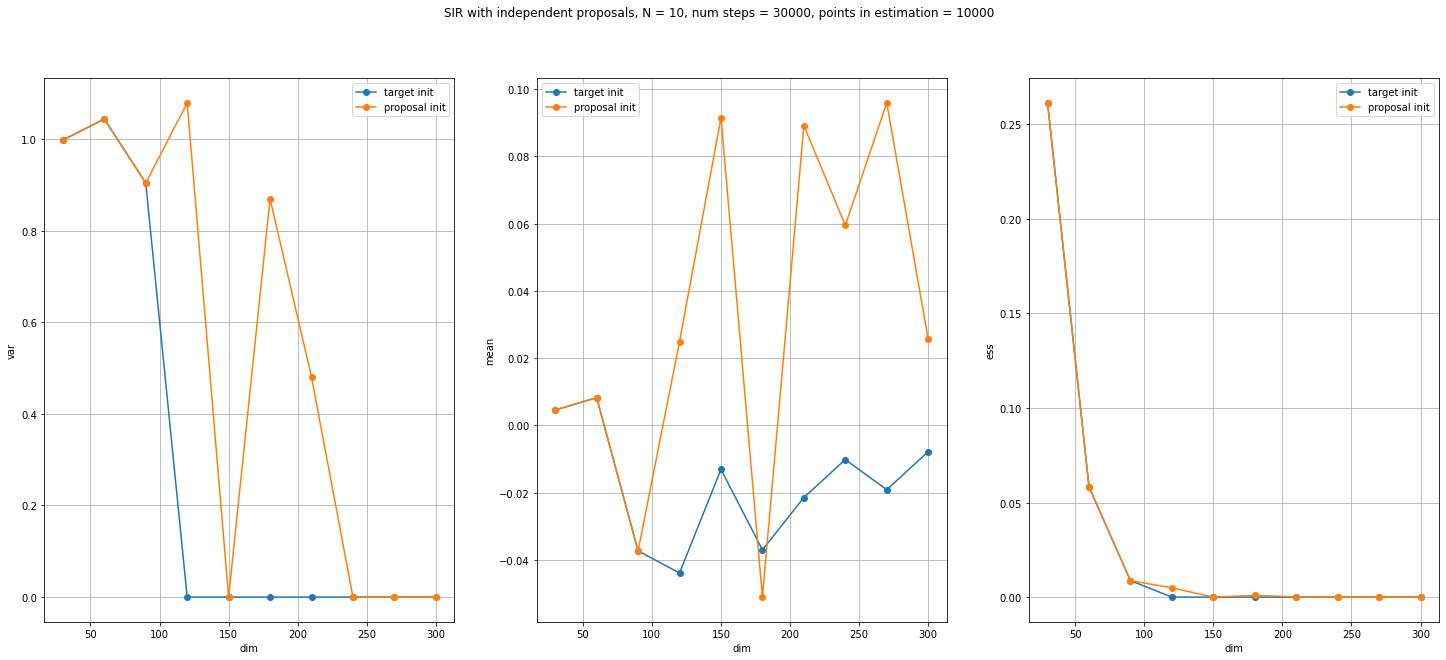

In [132]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 10))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

#axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

#axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    axs[i].plot(dim_arr, dict_results['target'][mode], label='target init', marker='o')
    axs[i].plot(dim_arr, dict_results['proposal'][mode], label='proposal init', marker='o')

for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

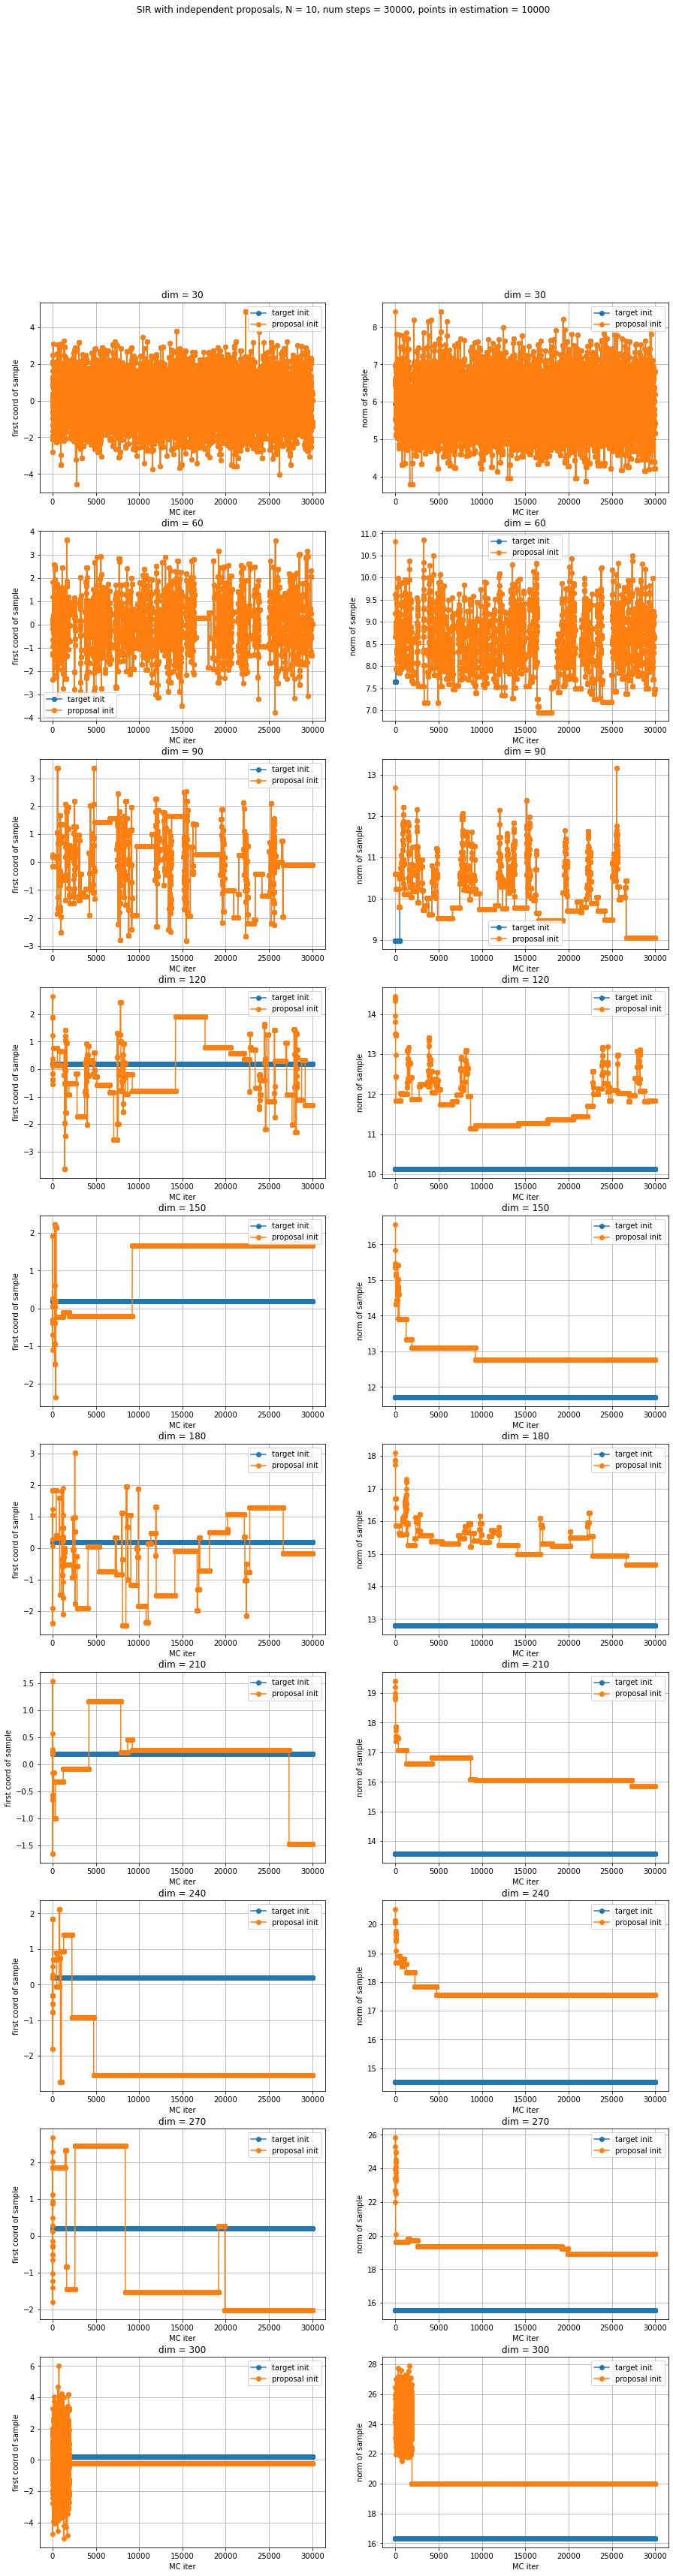

In [135]:
fig, axs = plt.subplots(ncols=2, nrows=10, figsize=(15, 55))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

for i, dim in enumerate(dim_arr):
    axs[i][0].set_xlabel('MC iter')
    axs[i][0].set_ylabel('first coord of sample')
    axs[i][0].plot(np.arange(len(dict_results['target']['history_first'][i])), 
                   dict_results['target']['history_first'][i], 
                   label=f'target init', marker='o')
    axs[i][0].plot(np.arange(len(dict_results['proposal']['history_first'][i])), 
                   dict_results['proposal']['history_first'][i], 
                   label=f'proposal init', marker='o')
    axs[i][0].set_title(f'dim = {dim}')
    axs[i][0].grid()
    axs[i][0].legend()

    axs[i][1].set_xlabel('MC iter')
    axs[i][1].set_ylabel('norm of sample')
    axs[i][1].plot(np.arange(len(dict_results['target']['history_norm'][i])), 
                   dict_results['target']['history_norm'][i], 
                   label='target init', marker='o')
    axs[i][1].plot(np.arange(len(dict_results['proposal']['history_norm'][i])), 
                   dict_results['proposal']['history_norm'][i], 
                   label=f'proposal init', marker='o')
    axs[i][1].set_title(f'dim = {dim}')
    axs[i][1].grid()
    axs[i][1].legend()


plt.show()    

In [112]:
def sir_correlated_dynamics(z, target, proposal, n_steps, N, alpha):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        z_copy = z.unsqueeze(1).repeat(1, N, 1)
        U = torch.randint(0, N, (batch_size,)).tolist()
        W = proposal.sample([batch_size, N])
        X = torch.zeros((batch_size, N, z_dim), dtype = z.dtype).to(z.device)
        X = W*(1- alpha**2)**0.5 + alpha*z_copy
        X[np.arange(batch_size), U, :] = z
        
        
        weight = compute_sir_weights(X)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]
        
        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()
        
        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
    z_sp.append(z)
    return z_sp

In [118]:
dim_arr = [30*(i + 1) for i in range(10)]
modes_init = ['target', 'proposal']
dict_results_correlated = {'target': {'mean_loc': [], 'mean_var': [], 
                                      'ess': [], 'history_first': [], 'history_norm': []}, 
                            'proposal': {'mean_loc': [], 'mean_var': [], 
                                         'ess': [], 'history_first': [], 'history_norm': []}}
batch_size = 1
N = 10 
n_steps = 30000
с = 1.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_seed = 42
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
for mode_init in modes_init:
    print(f"mode = {mode_init}")
    
    for dim in dim_arr:
        print(f"dim = {dim}")
        target = init_independent_normal(scale_target, dim, device)
        proposal = init_independent_normal(scale_proposal, dim, device)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        random.seed(random_seed)
        if mode_init == 'target':
            start = target.sample([batch_size])
        elif mode_init == 'proposal':
            start = proposal.sample([batch_size])
        alpha = (1 - с/dim)**0.5
        history = sir_correlated_dynamics(start, target, proposal, n_steps, N, alpha)
        if strategy_mean == 'starts':
            result = history[-1]
            result_np = result.cpu().numpy()
            result_var = np.var(result_np, axis = 0, ddof=1).mean()
            result_mean = np.mean(result_np, axis = 0).mean()
        elif strategy_mean == 'chain':
            result = history[-num_points_in_chain:-1]
            result = torch.stack(result, axis = 0).squeeze()
            result_np = result.cpu().numpy()
            print(result_np.shape)
            result_var = np.var(result_np, axis = 0, ddof=1).mean()
            result_mean = np.mean(result_np, axis = 0).mean()
            result_np_1 = result_np[:-1]
            result_np_2 = result_np[1:]
            diff = (result_np_1 == result_np_2).sum(axis = 1)
            num_new = (diff != dim).sum()
            ess = num_new/diff.shape[0]
            big_history = history
            big_result = torch.stack(big_history, axis = 0).squeeze()
            big_result_np = big_result.cpu().numpy()
            first_coord_history = big_result_np[:, 0]
            norm_history = np.linalg.norm(big_result_np, axis = 1)

        print(f"mean estimation of variance = {result_var}")
        print(f"mean estimation of mean = {result_mean}")
        print(f"ess = {ess}")
        dict_results_correlated[mode_init]['mean_loc'].append(result_mean)
        dict_results_correlated[mode_init]['mean_var'].append(result_var)
        dict_results_correlated[mode_init]['ess'].append(ess)
        dict_results_correlated[mode_init]['history_first'].append(first_coord_history)
        dict_results_correlated[mode_init]['history_norm'].append(norm_history)

mode = target
dim = 30
(9999, 30)
mean estimation of variance = 0.7363850474357605
mean estimation of mean = 0.0072790831327438354
ess = 0.884376875375075
dim = 60
(9999, 60)
mean estimation of variance = 0.7301313877105713
mean estimation of mean = 0.0023537634406238794
ess = 0.8827765553110622
dim = 90
(9999, 90)
mean estimation of variance = 0.7236562371253967
mean estimation of mean = -0.012706327252089977
ess = 0.8859771954390878
dim = 120
(9999, 120)
mean estimation of variance = 0.7360103726387024
mean estimation of mean = 0.00654595298692584
ess = 0.8840768153630726
dim = 150
(9999, 150)
mean estimation of variance = 0.7162710428237915
mean estimation of mean = 0.007068675942718983
ess = 0.883876775355071
dim = 180
(9999, 180)
mean estimation of variance = 0.7148740887641907
mean estimation of mean = 0.010036907158792019
ess = 0.8836767353470694
dim = 210
(9999, 210)
mean estimation of variance = 0.7086071372032166
mean estimation of mean = 0.018703706562519073
ess = 0.88467693

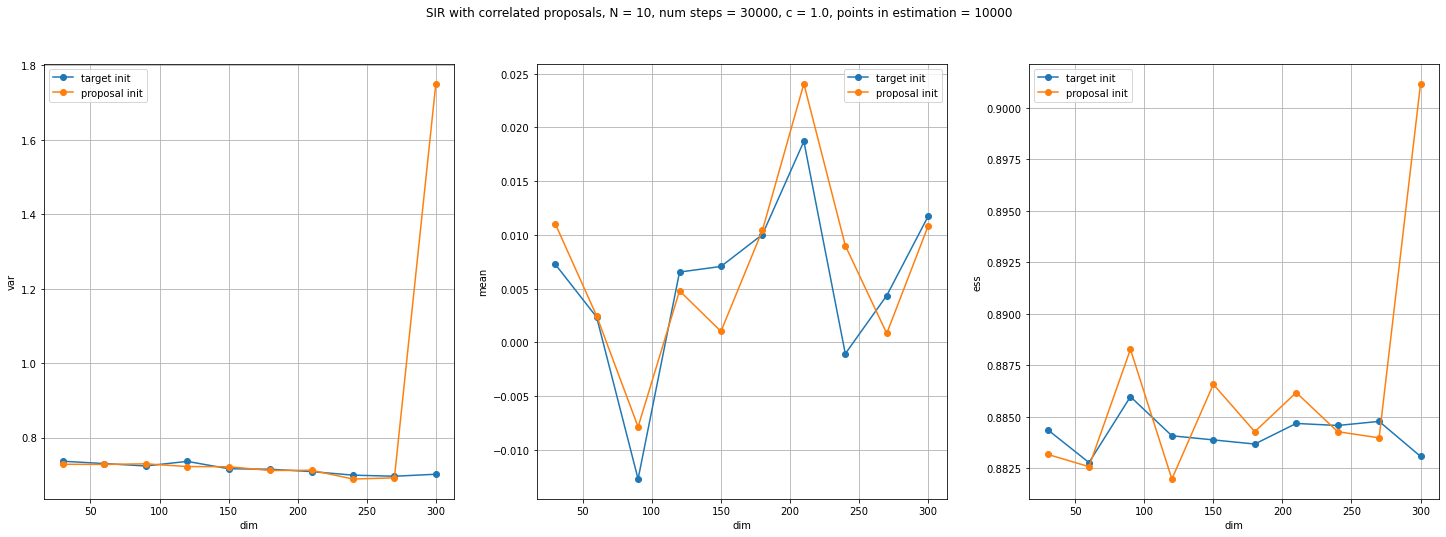

In [119]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {с}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    axs[i].plot(dim_arr, dict_results_correlated['target'][mode], label='target init', marker='o')
    axs[i].plot(dim_arr, dict_results_correlated['proposal'][mode], label='proposal init', marker='o')

for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

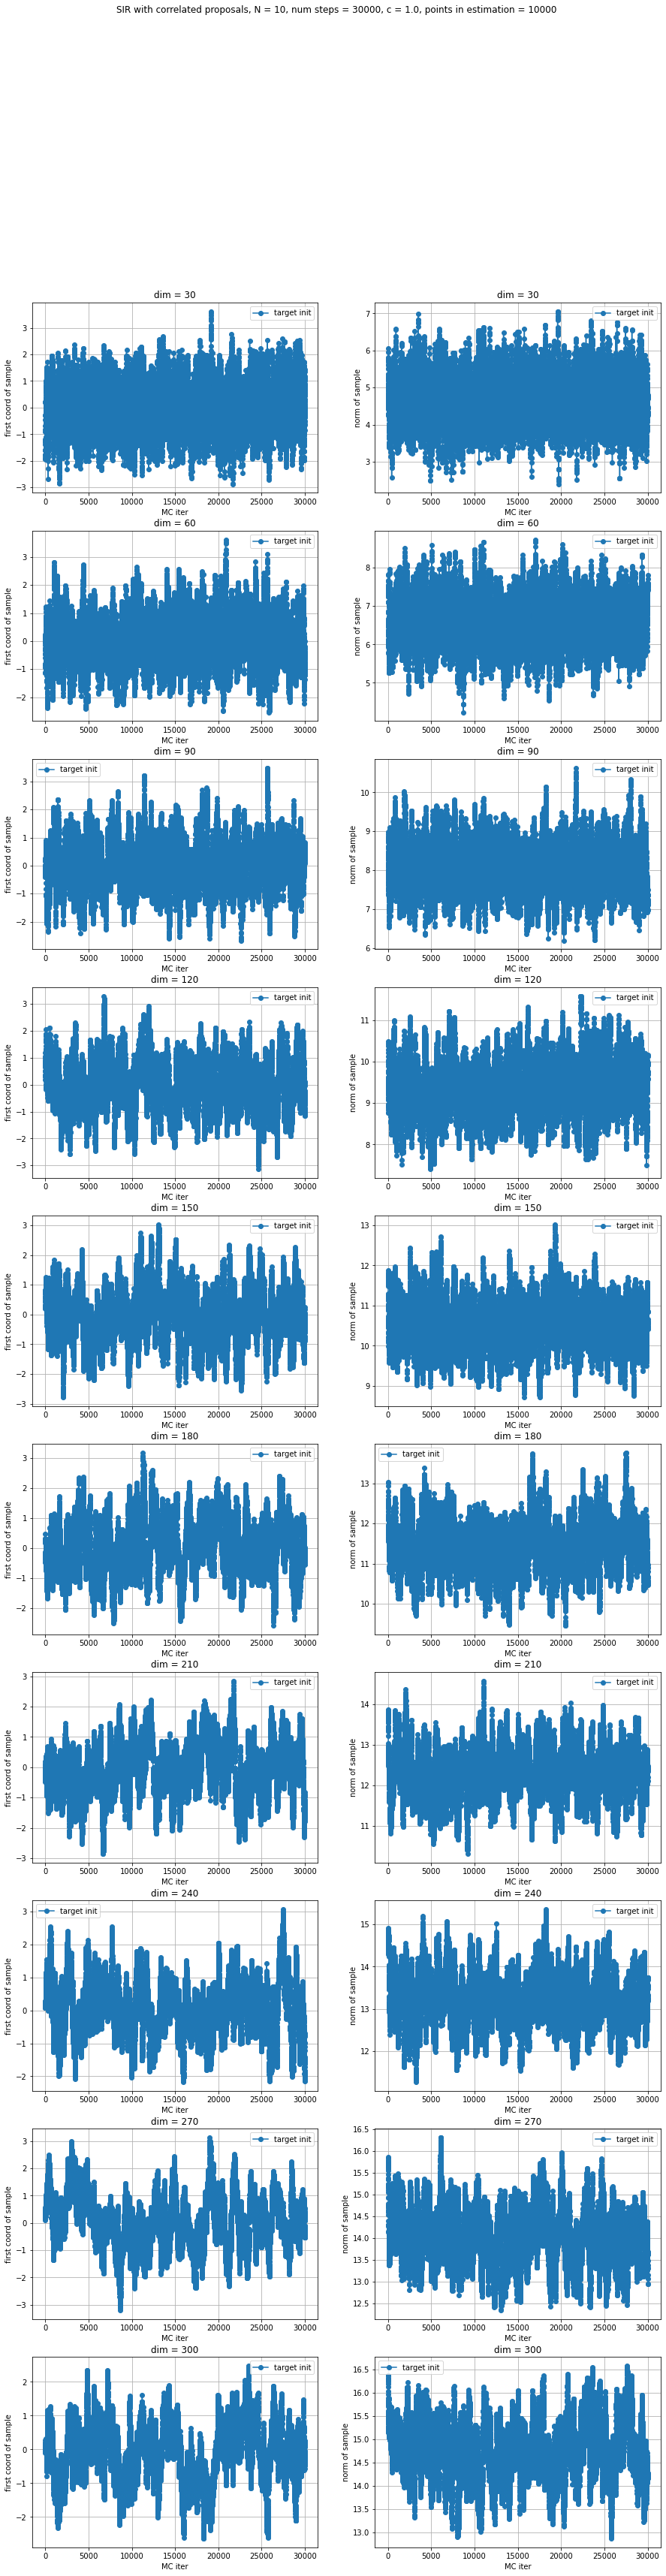

In [130]:
fig, axs = plt.subplots(ncols=2, nrows=10, figsize=(15, 55))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {с}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

for i, dim in enumerate(dim_arr):
    axs[i][0].set_xlabel('MC iter')
    axs[i][0].set_ylabel('first coord of sample')
    axs[i][0].plot(np.arange(len(dict_results_correlated['target']['history_first'][i])), 
                   dict_results_correlated['target']['history_first'][i], 
                   label=f'target init', marker='o')
    axs[i][0].set_title(f'dim = {dim}')
    axs[i][0].grid()
    axs[i][0].legend()

    axs[i][1].set_xlabel('MC iter')
    axs[i][1].set_ylabel('norm of sample')
    axs[i][1].plot(np.arange(len(dict_results_correlated['target']['history_norm'][i])), 
                   dict_results_correlated['target']['history_norm'][i], 
                   label='target init', marker='o')
    axs[i][1].set_title(f'dim = {dim}')
    axs[i][1].grid()
    axs[i][1].legend()


plt.show()    